In [27]:
from general_utils import *
from own_utils import *

In [28]:
# Corrector code

steps = 40
EbN0_dB = np.linspace(1, 10, steps)
EbN0 = 10**(EbN0_dB/10)  # Convert to linear scale

EbfN0 = EbN0 * n/k
EbfN0_dB = 10 * np.log10(EbfN0)

source_ber = np.zeros(steps)  # Source bit error rate

for i, ebn0 in enumerate(EbN0):
    trials = 10 / (0.5 * erfc(np.sqrt(ebn0))) # Thumbnail rule to reach a good approximation with dynamic trials
    print("trials(ebn0)", ebn0, trials)

    source_messages = np.random.randint(0, 2, (int(trials), k), dtype=np.uint8)

    encoded_messages = np.array([encode_message(msg, G) for msg in source_messages])
    received_codewords = noisy_channel(encoded_messages, n=n, k=k, EbfN0=ebn0)
    decoded_messages = decode_message(received_codewords, H, n)

    bit_errors = np.sum(source_messages != decoded_messages[:, :k], axis=1).astype(float)
    bit_errors /= k

    # Average the results over all trials
    source_ber[i] = np.mean(bit_errors)

trials(ebn0) 1.2589254117941673 177.6768510830619
trials(ebn0) 1.3276295892211267 193.78355255564503
trials(ebn0) 1.400083205615394 212.19140692707046
trials(ebn0) 1.476490881614259 233.31977206113558
trials(ebn0) 1.5570684047537309 257.68017818843276
trials(ebn0) 1.6420433388871631 285.89996180492204
trials(ebn0) 1.7316556668620833 318.75281739824965
trials(ebn0) 1.826158468270261 357.19854347966753
trials(ebn0) 1.9258186341850767 402.4350920649492
trials(ebn0) 2.0309176209047357 455.96719896644083
trials(ebn0) 2.14175224483001 519.6975239695269
trials(ebn0) 2.2586355207213766 596.0485840592722
trials(ebn0) 2.3818975457029214 688.1271460137801
trials(ebn0) 2.51188643150958 799.9476488188285
trials(ebn0) 2.648969287610528 936.7383991642084
trials(ebn0) 2.7935332579852212 1105.3648721362574
trials(ebn0) 2.945986614480108 1314.920232527953
trials(ebn0) 3.10675990983383 1577.5569550922537
trials(ebn0) 3.2763071936272294 1909.6695734476564
trials(ebn0) 3.45510729459222 2333.594184705668
tr

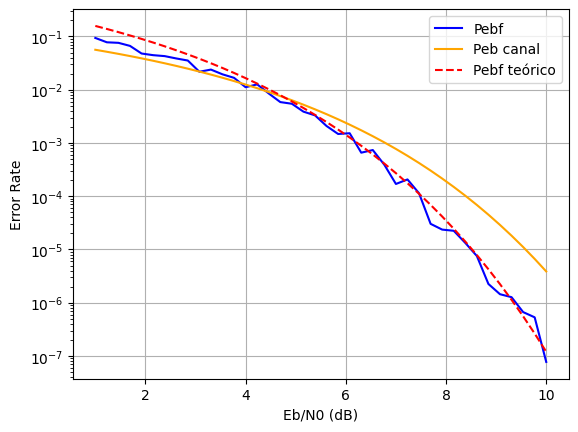

In [29]:
# Plots for corrector code

Peb = Q(np.sqrt(2 * EbN0))
p_canal = Q(np.sqrt(2 * EbN0 * k/n)) # Pebf del canal
Pebf = ((2*tc+1)/ n) * comb(n, tc+1) * (p_canal**(tc+1)) # (using valid approximation)

plt.semilogy(EbN0_dB, source_ber, 'b-', label='Pebf')
plt.semilogy(EbN0_dB, Peb, '-', color='orange', label='Peb canal')
plt.semilogy(EbN0_dB, Pebf, 'r--', label='Pebf teórico')

plt.plot(figsize=(14,6))
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.yscale('log')
plt.legend()
plt.show()

In [30]:
# Detector code

steps = 10
EbN0_dB = np.linspace(0, 8, steps)
EbN0 = 10**(EbN0_dB/10)  # Convert to linear scale

EbfN0 = EbN0 * n/k
EbfN0_dB = 10 * np.log10(EbfN0)

# Simulate error rates for coded and uncoded system, only with error detection
coded_wer = np.zeros(steps)  # Coded word error rate

for i, eb_n0 in enumerate(EbN0):
    trials = 10 / (0.5 * erfc(np.sqrt(eb_n0))) # Thumbnail rule to reach a good approximation with dynamic trials
    print("trials(eb_n0)", eb_n0, trials)

    attempts = 0
    while coded_wer[i] == 0: 
        print(attempts)
        source_messages = np.random.randint(0, 2, (int(trials), k))

        encoded_messages = np.array([encode_message(msg, G) for msg in source_messages])
        received_codewords = noisy_channel(encoded_messages, n=n, k=k, EbfN0=eb_n0)
        
        # Considering the detectable syndromes, we want to count how many errors are undetected
        syndromes = np.dot(received_codewords, H.T) % 2

        # Find indices where syndrome is all zeros (no errors detected)
        detected = ~np.any(syndromes, axis=1)  # True for undetected errors

        # Get only the undetected error cases
        Ve = received_codewords[detected] # Received codewords with undetected errors
        U = source_messages[np.where(detected)[0]] # Original source messages for undetected errors
        
        Ue = Ve[:, :k] # First k bits of received codewords
        E = U != Ue # Bit differences
        bit_differences = np.sum(E, axis=1) # Sum of bit errors per word
        word_errors = (bit_differences > 0).astype(float) # Word errors
        bit_errors = bit_differences / k # Bit error rates
        
        coded_wer[i] = np.mean(word_errors)
        attempts += 1
        if attempts == 300:
            break


trials(eb_n0) 1.0 127.14622263547986
0
trials(eb_n0) 1.22712523985119 170.63812085774637
0
trials(eb_n0) 1.5058363542798405 241.9346741512087
0
trials(eb_n0) 1.847849797422291 366.61662139910186
0
trials(eb_n0) 2.267543125870801 602.2865801796884
0
1
trials(eb_n0) 2.782559402207125 1091.5977661839681
0
1
2
3
4
5
6
7
8
9
trials(eb_n0) 3.4145488738336014 2230.0383191498727
0
1
2
3
4
5
trials(eb_n0) 4.190079105786668 5272.323393868008
0
1
2
3
4
5
6
7
8
9
trials(eb_n0) 5.141751827683925 14900.373059253196
0
1
2
trials(eb_n0) 6.309573444801933 52381.31369139205
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81


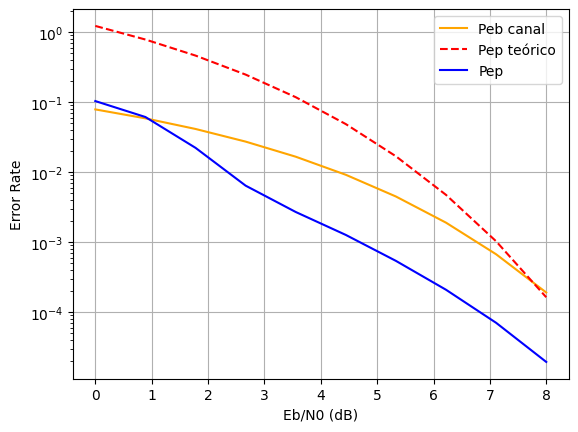

In [34]:
# Plots for corrector code

Peb = Q(np.sqrt(2 * EbN0))
p_canal = Q(np.sqrt(2 * EbN0 * k/n)) # Pebf del canal
Pew = comb(n, tc+1) * (p_canal**(tc+1)) # (using valid approximation)

plt.semilogy(EbN0_dB, Peb, '-', color='orange', label='Peb canal')
plt.semilogy(EbN0_dB, Pew, 'r--', label='Pep teórico')
plt.semilogy(EbN0_dB, coded_wer, 'b-', label='Pep')

plt.plot(figsize=(14,6))
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.yscale('log')
plt.legend()
plt.show()